# DL Modeling - Fine Tuning from Noiser Pre-Trained Model
Load a pre-trained model and fine tune it.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import pandas as pd
import numpy as np
import os 

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from kdd_utils import addFieldDataFtrs, addSoilFtrs, cvPerYear, load_model_ignoring, save_model_ignoring

sns.set(style="whitegrid")

/home/eraldo/miniconda2/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
from fastai.structured import *
from fastai.column_data import *

/home/eraldo/miniconda2/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/eraldo/miniconda2/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Train and test datasets

Basic data containing palm tree information

In [4]:
path = '../input/'

# Train data.
df_train = pd.read_csv(os.path.join(path, 'train.csv'))

# Ignoring date before 2006 for training.
# df_train = df_train[df_train.harvest_year >= 2006]

# Using only examples with type=5 for training.
# df_train = df_train[df_train.type == 5]

# Test data.
df_test  = pd.read_csv(os.path.join(path, 'test.csv'))

# Merge train and test data for ease of pre-processing.
df_all = pd.concat([df_train, df_test], sort=False).reindex()

# Configure number of jobs.
N_JOBS=7

print('Shapes\n---\nTrain: {}\n Test: {}\n  All: {}'.format(df_train.shape, df_test.shape, df_all.shape))

Shapes
---
Train: (5243, 7)
 Test: (4110, 6)
  All: (9353, 7)


## Field and Soil Features

These files hold atmospheric data from January 2002 to December 2017, and can be used to estimate the weather conditions during the development of the plant. Notice that weather does influence the production. Using only a single month prior to harvest is probably too little data. Participants should decide how far back in the past they want to look when training models.



In [5]:
df_all_ftrs = addFieldDataFtrs(df_all, shiftPeriod=12, shiftFtrs=['temperature', 'dewpoint', 'windspeed', 
                                                                 'Precipitation', 'Soilwater_L1', 
                                                                 'Soilwater_L2', 'Soilwater_L3', 
                                                                 'Soilwater_L4'])
#df_all_ftrs = addSoilFtrs(df_all_ftrs)
print(list(df_all_ftrs.columns))

['index', 'Id', 'field', 'age', 'type', 'harvest_year', 'harvest_month', 'production', 'temperature', 'dewpoint', 'windspeed', 'Soilwater_L1', 'Soilwater_L2', 'Soilwater_L3', 'Soilwater_L4', 'Precipitation', 'temperature_1', 'temperature_2', 'temperature_3', 'temperature_4', 'temperature_5', 'temperature_6', 'temperature_7', 'temperature_8', 'temperature_9', 'temperature_10', 'temperature_11', 'dewpoint_1', 'dewpoint_2', 'dewpoint_3', 'dewpoint_4', 'dewpoint_5', 'dewpoint_6', 'dewpoint_7', 'dewpoint_8', 'dewpoint_9', 'dewpoint_10', 'dewpoint_11', 'windspeed_1', 'windspeed_2', 'windspeed_3', 'windspeed_4', 'windspeed_5', 'windspeed_6', 'windspeed_7', 'windspeed_8', 'windspeed_9', 'windspeed_10', 'windspeed_11', 'Precipitation_1', 'Precipitation_2', 'Precipitation_3', 'Precipitation_4', 'Precipitation_5', 'Precipitation_6', 'Precipitation_7', 'Precipitation_8', 'Precipitation_9', 'Precipitation_10', 'Precipitation_11', 'Soilwater_L1_1', 'Soilwater_L1_2', 'Soilwater_L1_3', 'Soilwater_L1_4

In [6]:
df_all_ftrs.head()

,index,Id,field,age,type,harvest_year,harvest_month,production,temperature,dewpoint,...,Soilwater_L4_2,Soilwater_L4_3,Soilwater_L4_4,Soilwater_L4_5,Soilwater_L4_6,Soilwater_L4_7,Soilwater_L4_8,Soilwater_L4_9,Soilwater_L4_10,Soilwater_L4_11
0,0,0,0,19,5,2004,1,0.064071,26.132,24.661,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165
1,1,1532,0,13,2,2004,1,0.283228,26.132,24.661,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165
2,2,4204,0,4,5,2004,1,0.106263,26.132,24.661,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165
3,3,1,0,19,5,2004,2,0.047658,25.295,24.401,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165
4,4,1533,0,13,2,2004,2,0.182068,25.295,24.401,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165


In [7]:
# Categorical features.
cat_ftrs = ['field', 'age', 'type', 'harvest_month']
# Continuous features.
contin_ftrs = [f for f in df_all_ftrs.columns if f not in (['production', 'Id', 'index'] + cat_ftrs)]
print(contin_ftrs)

['harvest_year', 'temperature', 'dewpoint', 'windspeed', 'Soilwater_L1', 'Soilwater_L2', 'Soilwater_L3', 'Soilwater_L4', 'Precipitation', 'temperature_1', 'temperature_2', 'temperature_3', 'temperature_4', 'temperature_5', 'temperature_6', 'temperature_7', 'temperature_8', 'temperature_9', 'temperature_10', 'temperature_11', 'dewpoint_1', 'dewpoint_2', 'dewpoint_3', 'dewpoint_4', 'dewpoint_5', 'dewpoint_6', 'dewpoint_7', 'dewpoint_8', 'dewpoint_9', 'dewpoint_10', 'dewpoint_11', 'windspeed_1', 'windspeed_2', 'windspeed_3', 'windspeed_4', 'windspeed_5', 'windspeed_6', 'windspeed_7', 'windspeed_8', 'windspeed_9', 'windspeed_10', 'windspeed_11', 'Precipitation_1', 'Precipitation_2', 'Precipitation_3', 'Precipitation_4', 'Precipitation_5', 'Precipitation_6', 'Precipitation_7', 'Precipitation_8', 'Precipitation_9', 'Precipitation_10', 'Precipitation_11', 'Soilwater_L1_1', 'Soilwater_L1_2', 'Soilwater_L1_3', 'Soilwater_L1_4', 'Soilwater_L1_5', 'Soilwater_L1_6', 'Soilwater_L1_7', 'Soilwater_L1

In [8]:
# Remove unused features.
df_all_ftrs = df_all_ftrs[cat_ftrs + contin_ftrs + ['production']]
df_all_ftrs.head(2)

,field,age,type,harvest_month,harvest_year,temperature,dewpoint,windspeed,Soilwater_L1,Soilwater_L2,...,Soilwater_L4_3,Soilwater_L4_4,Soilwater_L4_5,Soilwater_L4_6,Soilwater_L4_7,Soilwater_L4_8,Soilwater_L4_9,Soilwater_L4_10,Soilwater_L4_11,production
0,0,19,5,1,2004,26.132,24.661,1.8766,0.35274,0.35192,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.064071
1,0,13,2,1,2004,26.132,24.661,1.8766,0.35274,0.35192,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.283228


In [9]:
# Inform pandas which features are categorical ...
for v in cat_ftrs:
    df_all_ftrs[v] = df_all_ftrs[v].astype('category').cat.as_ordered()
# ... and which are continuous.
for v in contin_ftrs:
    df_all_ftrs[v] = df_all_ftrs[v].astype('float32')

df_all_ftrs.head(2)

,field,age,type,harvest_month,harvest_year,temperature,dewpoint,windspeed,Soilwater_L1,Soilwater_L2,...,Soilwater_L4_3,Soilwater_L4_4,Soilwater_L4_5,Soilwater_L4_6,Soilwater_L4_7,Soilwater_L4_8,Soilwater_L4_9,Soilwater_L4_10,Soilwater_L4_11,production
0,0,19,5,1,2004.0,26.132,24.660999,1.8766,0.35274,0.35192,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.064071
1,0,13,2,1,2004.0,26.132,24.660999,1.8766,0.35274,0.35192,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.283228


In [10]:
# Split test and train data.
df_test = df_all_ftrs[df_all_ftrs.production.isna()]
df_all_ftrs = df_all_ftrs[~df_all_ftrs.production.isna()]

In [11]:
val_year = 2010

# Ignore training examples with type != 5
# df_all_ftrs = df_all_ftrs[(df_all_ftrs.type == 5) | (df_all_ftrs.harvest_year >= val_year)]

# Ignore training examples before 2006
# df_all_ftrs = df_all_ftrs[df_all_ftrs.harvest_year >= 2006]

val_idx = np.flatnonzero(df_all_ftrs.harvest_year >= val_year)
print(len(val_idx))
print(len(df_all_ftrs))

1387
5243


In [12]:
df, y, nas, mapper = proc_df(df_all_ftrs, y_fld='production', do_scale=True)
df.head(2)

,field,age,type,harvest_month,harvest_year,temperature,dewpoint,windspeed,Soilwater_L1,Soilwater_L2,...,Soilwater_L4_2,Soilwater_L4_3,Soilwater_L4_4,Soilwater_L4_5,Soilwater_L4_6,Soilwater_L4_7,Soilwater_L4_8,Soilwater_L4_9,Soilwater_L4_10,Soilwater_L4_11
0,1,17,7,1,-1.626713,-1.014467,0.894659,-0.616689,0.894475,0.896105,...,-0.117815,-0.128899,-0.137128,-0.144918,-0.144076,-0.142981,-0.137557,-0.12906,-0.117197,-0.101698
1,1,11,4,1,-1.626713,-1.014467,0.894659,-0.616689,0.894475,0.896105,...,-0.117815,-0.128899,-0.137128,-0.144918,-0.144076,-0.142981,-0.137557,-0.12906,-0.117197,-0.101698


In [13]:
df_test, _, nas, mapper = proc_df(df_test, y_fld='production', do_scale=True, mapper=mapper, na_dict=nas)

In [14]:
cat_sz = [(c, len(df_all_ftrs[c].cat.categories)+1) for c in cat_ftrs]
print(cat_sz)
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
print(emb_szs)

[('field', 29), ('age', 29), ('type', 10), ('harvest_month', 13)]
[(29, 15), (29, 15), (10, 5), (13, 7)]


In [15]:
md = ColumnarModelData.from_data_frame(path, # path for data saving
                                       val_idx, # indexes of validation examples
                                       df, # training data
                                       y.astype(np.float32), # output variable
                                       cat_flds=cat_ftrs, # categorical features
                                       bs=16, # batch size
                                       test_df=df_test) # test dataframe

 77%|███████▋  | 185/241 [00:01<00:00, 179.63it/s, loss=3.66]


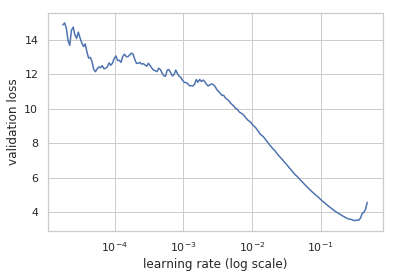

In [16]:
# dropout rate
dr = 0.3

learner_params = {
    "emb_szs": emb_szs, # embedding sizes
    "n_cont": len(df.columns) - len(cat_ftrs), # num continuous inputs
    "emb_drop": dr, # embeddings dropout probability
    "out_sz": 1, # output size
    "szs": [300, 100], # sizes of fully-connected layers
    "drops": [dr, dr], # dropout probabilities after each FC layer
    "use_bn": False # batch normalization
}

m = md.get_learner(**learner_params)

load_model_ignoring(m, 'pretrain-noiser-trn083-val064')

m.freeze_to(-1)

m.lr_find()
m.sched.plot()

In [17]:
# dropout rate
dr = 0.5

learner_params = {
    "emb_szs": emb_szs, # embedding sizes
    "n_cont": len(df.columns) - len(cat_ftrs), # num continuous inputs
    "emb_drop": dr, # embeddings dropout probability
    "out_sz": 1, # output size
    "szs": [300, 100], # sizes of fully-connected layers
    "drops": [dr, dr], # dropout probabilities after each FC layer
    "use_bn": False # batch normalization
}

m = md.get_learner(**learner_params)

load_model_ignoring(m, 'pretrain-noiser-trn083-val064')

m.freeze_to(-1)

lr = 1e-3
m.fit(lr, 20, cycle_len=3, metrics=[metrics.mean_absolute_error])

epoch      trn_loss   val_loss   mean_absolute_error         
    0      11.255898  3.85067    1.638397  
    1      6.59884    1.877655   1.104691                    
    2      5.683508   1.562555   0.998267                    
    3      2.554582   0.490685   0.530262                    
    4      1.249022   0.258976   0.384413                    
    5      1.032062   0.223184   0.35558                     
    6      0.409463   0.07372    0.202534                     
    7      0.169561   0.049889   0.164423                     
    8      0.144533   0.045841   0.157911                     
    9      0.053234   0.028013   0.115022                      
    10     0.032412   0.024414   0.107262                      
    11     0.026266   0.02357    0.105365                      
    12     0.020807   0.024221   0.104375                      
    13     0.019003   0.021642   0.100295                      
    14     0.017266   0.021811   0.100266                      
    15     

[array([0.02083]), 0.09755155422658308]

In [19]:
m.save('finetuned-noiser-val097')

In [18]:
# # dropout rate
# dr = 0.3

# learner_params = {
#     "emb_szs": emb_szs, # embedding sizes
#     "n_cont": len(df.columns) - len(cat_ftrs), # num continuous inputs
#     "emb_drop": dr, # embeddings dropout probability
#     "out_sz": 1, # output size
#     "szs": [300, 100], # sizes of fully-connected layers
#     "drops": [dr, dr], # dropout probabilities after each FC layer
#     "use_bn": False # batch normalization
# }

# m = md.get_learner(**learner_params)

# m.load('finetuned-noiser-val097')
m.unfreeze()

lr=1e-3
lrs=[lr/100, lr/10, lr]
m.fit(lrs, 20, cycle_len=3, metrics=[metrics.mean_absolute_error])

epoch      trn_loss   val_loss   mean_absolute_error           
    0      0.021722   0.020003   0.095346  
    1      0.017016   0.020521   0.099368                      
    2      0.016379   0.02035    0.099368                      
    3      0.01955    0.020306   0.096325                      
    4      0.015379   0.020468   0.096579                      
    5      0.013864   0.020145   0.097458                      
    6      0.016173   0.021527   0.098157                      
    7      0.017269   0.020312   0.09564                       
    8      0.012836   0.019447   0.093816                      
    9      0.01921    0.019431   0.097108                      
    10     0.013694   0.019387   0.092367                      
    11     0.014392   0.019712   0.093447                      
    12     0.017487   0.018239   0.092335                      
    13     0.014327   0.019956   0.095978                      
    14     0.016956   0.019007   0.092354                   

[array([0.01831]), 0.09039336044902671]

In [19]:
m.save('finetuned-all-noiser-val0903')

In [40]:
# dropout rate
dr = 0.3

learner_params = {
    "emb_szs": emb_szs, # embedding sizes
    "n_cont": len(df.columns) - len(cat_ftrs), # num continuous inputs
    "emb_drop": dr/10, # embeddings dropout probability
    "out_sz": 1, # output size
    "szs": [300, 100], # sizes of fully-connected layers
    "drops": [dr, dr], # dropout probabilities after each FC layer
    "use_bn": False # batch normalization
}

m = md.get_learner(**learner_params)

m.load('finetuned-all-noiser-val0914')
m.unfreeze()

lr=1e-3
lrs=[lr/100, lr/10, lr]
m.fit(lrs, 10, cycle_len=3, metrics=[metrics.mean_absolute_error])

epoch      trn_loss   val_loss   mean_absolute_error           
    0      0.012754   0.018446   0.09949   
    1      0.010231   0.018336   0.096624                      
    2      0.010281   0.018567   0.097584                       
    3      0.012565   0.021298   0.108995                      
    4      0.009049   0.020291   0.103993                       
    5      0.009402   0.019868   0.103746                       
    6      0.011561   0.018877   0.095768                      
    7      0.010511   0.018661   0.098932                       
    8      0.007571   0.019677   0.101775                       
    9      0.010664   0.023185   0.113344                      
    10     0.010405   0.020358   0.104538                       
    11     0.009939   0.020073   0.103077                       
    12     0.010142   0.017957   0.096723                       
    13     0.009624   0.019102   0.099795                       
    14     0.009558   0.019785   0.102626          

[array([0.02103]), 0.10671638075877371]

In [35]:
m.unfreeze()
lr=1e-3
lrs=[lr/100, lr/10, lr]
m.fit(lrs, 15, cycle_len=3, metrics=[metrics.mean_absolute_error])

epoch      trn_loss   val_loss   mean_absolute_error            
    0      0.008564   0.020098   0.100404  
    1      0.007157   0.019982   0.099726                       
    2      0.006635   0.019504   0.098065                       
    3      0.008911   0.020026   0.101369                       
    4      0.008677   0.019492   0.097606                       
    5      0.007693   0.019616   0.097643                       
    6      0.007901   0.024992   0.113276                       
    7      0.007413   0.023595   0.108221                       
    8      0.00709    0.022298   0.105144                       
    9      0.008326   0.022349   0.105955                       
    10     0.007184   0.020229   0.099998                       
    11     0.006297   0.019991   0.099361                       
    12     0.007112   0.020279   0.097539                       
    13     0.007298   0.020999   0.100172                       
    14     0.006559   0.020871   0.099599     

[array([0.02104]), 0.09933671390432287]

## Submission file

In [73]:
# dropout rate
dr = 0.3

learner_params = {
    "emb_szs": emb_szs, # embedding sizes
    "n_cont": len(df.columns) - len(cat_ftrs), # num continuous inputs
    "emb_drop": dr, # embeddings dropout probability
    "out_sz": 1, # output size
    "szs": [300, 100], # sizes of fully-connected layers
    "drops": [dr, dr], # dropout probabilities after each FC layer
    "use_bn": False # batch normalization
}

m = md.get_learner(**learner_params)

m.load('finetuned-all-082')

In [84]:
from datetime import datetime

# Make prediction.
pred = m.predict(is_test=True).squeeze()

now = datetime.now().strftime('%Y-%m-%d-%H-%M-%S-%f')

df_test_id = df_test # pd.read_csv(os.path.join(path, 'test.csv'))

submission_file  = '../submissions/{}.submission.csv'.format(now)
model_file       = '../submissions/{}.model'.format(now)

# Create a submission file.
with open(submission_file, 'w') as f:
    f.write("Id,production\n")
    for _id, _pred in zip(df_test_id.Id.values, pred):
        f.write("{},{}\n".format(_id, min(1.0, max(0.0, _pred))))

# Save model.
save_model(m.model, model_file)

[autoreload of urllib3.packages.six failed: Traceback (most recent call last):
  File "/home/eraldo/miniconda2/envs/fastai/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/eraldo/miniconda2/envs/fastai/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 384, in superreload
    update_generic(old_obj, new_obj)
  File "/home/eraldo/miniconda2/envs/fastai/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 323, in update_generic
    update(a, b)
  File "/home/eraldo/miniconda2/envs/fastai/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 275, in update_class
    old_obj = getattr(old, key)
  File "/home/eraldo/miniconda2/envs/fastai/lib/python3.6/site-packages/urllib3/packages/six.py", line 93, in __get__
    setattr(obj, self.name, result)  # Invokes __set__.
AttributeError: 'NoneType' object has no attribute 'cStringIO'
]
[autoreload of urllib3.co

AttributeError: 'DataFrame' object has no attribute 'Id'

In [82]:
pred = m.predict(is_test=True)
pred.squeeze()

array([0.08109, 0.24406, 0.08957, ..., 0.06683, 0.24095, 0.26506], dtype=float32)